# 도구 호출 에이전트(Tool Calling Agent)
도구 호출을 사용하면 모델이 하나 이상의 `도구(tool)` 가 `호출되어야 하는 시기를 감지하고 해당 도구에 전달해야 하는 입력` 으로 전달할 수 있습니다.

API 호출에서 도구를 설명하고 모델이 이러한 도구를 호출하기 위한 인수가 포함된 JSON과 같은 구조화된 객체를 출력하도록 지능적으로 선택할 수 있습니다.

도구 API 의 목표는 일반 텍스트 완성이나 채팅 API를 사용하여 수행할 수 있는 것보다 더 안정적으로 유효하고 유용한 `도구 호출(tool call)` 을 반환하는 것입니다.

이러한 구조화된 출력을 도구 호출 채팅 모델에 여러 도구를 바인딩하고 모델이 호출할 도구를 선택할 수 있다는 사실과 결합하여 쿼리가 해결될 때까지 반복적으로 도구를 호출하고 결과를 수신하는 에이전트를 만들 수 있습니다.

이것은 OpenAI 의 특정 도구 호출 스타일에 맞게 설계된 OpenAI 도구 에이전트의 보다 `일반화된 버전` 입니다.

이 에이전트는 LangChain의 ToolCall 인터페이스를 사용하여 OpenAI 외에도 Anthropic, Google Gemini, Mistral과 같은 더 광범위한 공급자 구현을 지원합니다.

**참고링크**  https://python.langchain.com/v0.1/docs/modules/agents/agent_types/tool_calling/

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from langchain_teddynote import logging
logging.langsmith("CH15-Agents") 

LangSmith 추적을 시작합니다.
[프로젝트명]
CH15-Agents


In [3]:
from langchain.tools import tool
from typing import List, Dict, Annotated
from langchain_teddynote.tools import GoogleNews
from langchain_experimental.utilities import PythonREPL

In [4]:
# 뉴스 검색 도구 생성
@tool
def search_news(query: str) -> List[Dict[str, str]]:
    """Search GoogleNews by input keyword"""
    news_tool = GoogleNews()
    return news_tool.search_by_keyword(query, k=5)

In [6]:
# 파이썬 코드 실행 도구
@tool
def python_repl_tool(
    code: Annotated[str, "The python code to ececute to generate your chart."]
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    result = ""
    try:
        result = PythonREPL().run(code)
    except BaseException as e:
        print(f"Failed to execute. Error: {repr(e)}")
    finally:
        return result

In [10]:
print(search_news)
print(python_repl_tool)
print(f"도구 이름: {search_news.name}")
print(f"도구 설명: {search_news.description}")
print(f"도구 이름: {python_repl_tool.name}")
print(f"도구 설명: {python_repl_tool.description}")

name='search_news' description='Search GoogleNews by input keyword' args_schema=<class 'pydantic.v1.main.search_newsSchema'> func=<function search_news at 0x000001E4F90F3D80>
name='python_repl_tool' description='Use this to execute python code. If you want to see the output of a value,\n    you should print it out with `print(...)`. This is visible to the user.' args_schema=<class 'pydantic.v1.main.python_repl_toolSchema'> func=<function python_repl_tool at 0x000001E4F91CE340>
도구 이름: search_news
도구 설명: Search GoogleNews by input keyword
도구 이름: python_repl_tool
도구 설명: Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user.


In [11]:
# 도구 정의
tools = [search_news, python_repl_tool]

### Agent 프롬프트 정의
- `chat_history` : 이전 대화 내용을 저장하는 변수 (멀티턴을 지원하지 않는다면, 생략 가능합니다.)
- `agent_scratchpad` : 에이전트가 임시로 저장하는 변수
- `input` : 사용자의 입력

### AgentExecutor
AgentExecutor는 도구를 사용하는 에이전트를 실행하는 클래스입니다.

**주요 속성**

- `agent`: 실행 루프의 각 단계에서 계획을 생성하고 행동을 결정하는 에이전트
- `tools`: 에이전트가 사용할 수 있는 유효한 도구 목록
- `return_intermediate_steps`: 최종 출력과 함께 에이전트의 중간 단계 경로를 반환할지 여부
- `max_iterations`: 실행 루프를 종료하기 전 최대 단계 수
- `max_execution_time`: 실행 루프에 소요될 수 있는 최대 시간
- `early_stopping_method`: 에이전트가 AgentFinish를 반환하지 않을 때 사용할 조기 종료 방법. ("force" or "generate")
    - `"force"` 는 시간 또는 반복 제한에 도달하여 중지되었다는 문자열을 반환합니다.
    - `"generate"` 는 에이전트의 LLM 체인을 마지막으로 한 번 호출하여 이전 단계에 따라 최종 답변을 생성합니다.
- `handle_parsing_errors`: 에이전트의 출력 파서에서 발생한 오류 처리 방법. (True, False, 또는 오류 처리 함수)
- `trim_intermediate_steps`: 중간 단계를 트리밍하는 방법. (-1 trim 하지 않음, 또는 트리밍 함수)

**주요 메서드**

1. `invoke`: 에이전트 실행
2. `stream`: 최종 출력에 도달하는 데 필요한 단계를 스트리밍

**주요 기능**

1. 도구 검증: 에이전트와 호환되는 도구인지 확인
2. 실행 제어: 최대 반복 횟수 및 실행 시간 제한 설정 가능
3. 오류 처리: 출력 파싱 오류에 대한 다양한 처리 옵션 제공
4. 중간 단계 관리: 중간 단계 트리밍 및 반환 옵션
5. 비동기 지원: 비동기 실행 및 스트리밍 지원

**최적화 팁**

- `max_iterations`와 `max_execution_time`을 적절히 설정하여 실행 시간 관리
- `trim_intermediate_steps`를 활용하여 메모리 사용량 최적화
- 복잡한 작업의 경우 `stream` 메서드를 사용하여 단계별 결과 모니터링

In [12]:
from langchain_core.prompts import ChatPromptTemplate

# 프롬프트 생성
# 프롬프트는 에이전트에게 모델이 수행할 작업을 설명하는 텍스트를 제공합니다. (도구의 이름과 역할을 입력)
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant. "
            "Make sure to use the `search_news` tool for searching keyword related news.",
        ),
        ("placeholder", "{chat_history}"),
        ("human", "{input}"),
        ("placeholder", "{agent_scratchpad}"),
    ]
)

In [13]:
# Agent 생성
from langchain_openai import ChatOpenAI
from langchain.agents import create_tool_calling_agent

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
agent = create_tool_calling_agent(llm, tools, prompt)

In [18]:
# AgentExecutor
from langchain.agents import AgentExecutor

agent_executor = AgentExecutor(
    agent=agent,
    tools=tools,
    verbose=True,
    # max_iterations=10,
    # max_execution_time=10,
    # handle_parsing_errors=True,
)

In [22]:
result = agent_executor.invoke({"input": "AI투자와 관련된 뉴스를 검색해주세요"})
print("Agent 실행 결과:")
print(result["output"])



> Entering new AgentExecutor chain...

Invoking: `search_news` with `{'query': 'AI 투자'}`


[{'url': 'https://news.google.com/rss/articles/CBMiakFVX3lxTE81QVlXam1wclZOV3loQndWUjVjU3FKUE9zMzRjbkU5b3RMSjFBaGVfMHBvM28wRDFyd05yMVhQYTVnZy1nVkhGZXBqLTV2Zks5bnFQdG8wVEtBeEJoZllhVkQwQ2d1MENteEE?oc=5', 'content': '오픈AI, 투자 유치 이후 글로벌 확장...뉴욕·파리·싱가포르 등 5곳에 지사 개설 - AI타임스'}, {'url': 'https://news.google.com/rss/articles/CBMiVkFVX3lxTE9FdmQ4S2VSMmowbU0yYmVMRkxQNjk5Z2EzRGR5LWJFZVZuYVBvLUhoakYwd0tiM2tGczFfZm16TXJCbDYtbjI4eDg5WUlaVWRzeGx1X2F3?oc=5', 'content': '오펜하이머 "MS,오픈AI 투자 손실 위험"…\'중립\'하향 - 네이트 뉴스'}, {'url': 'https://news.google.com/rss/articles/CBMiTkFVX3lxTE5CX19HNHE1bkF2U1VCeWE5T0ZJQVJIbWZZcHdFMEg2N3FPZ2ZSRnYyazRUSWhGcV9wajFzQl9zRUdxbzJORG1GT0xBN1A1UQ?oc=5', 'content': 'AI 스타트업 보이저엑스, 165억 원 신규 투자 유치 - 매일경제'}, {'url': 'https://news.google.com/rss/articles/CBMiVkFVX3lxTFBaN3Z4eDhSNTBhamJPQ1hIb0pCeDdBR2N4dmpoQjJYZ1VYMkc0ZEFqN2lPREJNT3AtLTB3c3VHQTBrRHoxZ0JxcnNHcTZmb1JaOUxYZVBR?oc=5', 'content': '

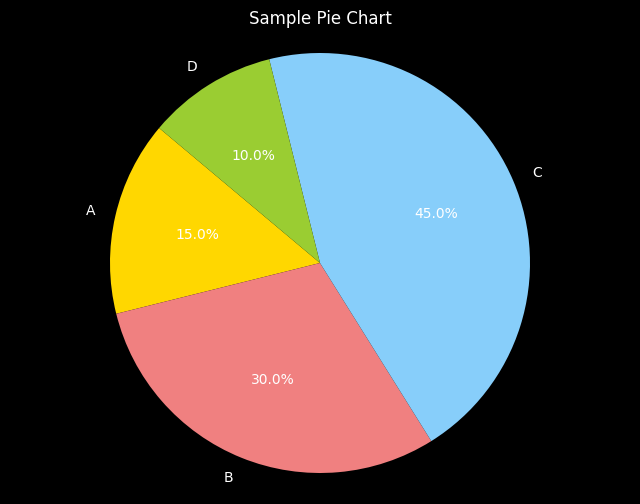

Agent 실행 결과:
아래는 Matplotlib을 사용하여 파이 차트를 그리는 코드입니다.

```python
import matplotlib.pyplot as plt

# 데이터
sizes = [15, 30, 45, 10]
labels = ['A', 'B', 'C', 'D']
colors = ['gold', 'lightcoral', 'lightskyblue', 'yellowgreen']

# 파이 차트 그리기
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Sample Pie Chart')

# 차트 보여주기
plt.show()
```

이 코드는 4개의 카테고리(A, B, C, D)에 대한 비율을 나타내는 파이 차트를 생성합니다. 각 카테고리는 서로 다른 색상으로 표시되며, 비율도 차트에 표시됩니다.


In [30]:
result = agent_executor.invoke({"input": "matplotlib 을 사용하여 pie 차트를 그리는 코드를 작성하고 실행하세요. 해당 코드도 알려주세요"})
print("Agent 실행 결과:")
print(result["output"])

# Stream 출력으로 단계별 결과 확인
`AgentExecutor`의 `stream() `메소드를 사용하여 에이전트의 중간 단계를 스트리밍할 것입니다.

`stream()`의 출력은 `(Action, Observation)` 쌍 사이에서 번갈아 나타나며, 최종적으로 에이전트가 목표를 달성했다면 답변으로 마무리됩니다.

다음과 같은 형태로 보일 것입니다.

1. Action 출력
2. Observation 출력
3. Action 출력
4. Observation 출력
... (목표 달성까지 계속) ...

그 다음, 최종 목표가 달성되면 에이전트는 최종 답변을 출력할 것입니다.

이러한 출력의 내용은 다음과 같이 요약됩니다.
| 출력         | 내용                                                                                     |
|------------|----------------------------------------------------------------------------------------|
| Action     | actions: AgentAction 또는 그 하위 클래스 <br> messages: 액션 호출에 해당하는 채팅 메시지        |
| Observation| steps: 현재 액션과 그 관찰을 포함한 에이전트가 지금까지 수행한 작업의 결과 <br> messages: 함수 호출 결과(즉, 관찰)를 포함한 채팅 메시지 |
| Final Answer | output: AgentFinish <br> messages: 최종 출력을 포함한 채팅 메시지   


In [23]:
from langchain.agents import AgentExecutor

# AgentExecutor 생성
agent_executor = AgentExecutor(
    agent=agent,
    tools=tools,
    verbose=False,
    handle_parsing_errors=True,
)

In [24]:
# 스트리밍 모드 실행
result = agent_executor.stream({"input": "AI 투자와 관련된 뉴스를 검색해 주세요."}) 

for step in result:
    # 중간 단계 출력
    print(step)

{'actions': [ToolAgentAction(tool='search_news', tool_input={'query': 'AI 투자'}, log="\nInvoking: `search_news` with `{'query': 'AI 투자'}`\n\n\n", message_log=[AIMessageChunk(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_DwkZlXx8rWc4sZ3TnxbP4gkA', 'function': {'arguments': '{"query":"AI 투자"}', 'name': 'search_news'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_e2bde53e6e'}, id='run-6fae9426-5be1-4bbb-84b0-f7ca3b7ba9b0', tool_calls=[{'name': 'search_news', 'args': {'query': 'AI 투자'}, 'id': 'call_DwkZlXx8rWc4sZ3TnxbP4gkA', 'type': 'tool_call'}], tool_call_chunks=[{'name': 'search_news', 'args': '{"query":"AI 투자"}', 'id': 'call_DwkZlXx8rWc4sZ3TnxbP4gkA', 'index': 0, 'type': 'tool_call_chunk'}])], tool_call_id='call_DwkZlXx8rWc4sZ3TnxbP4gkA')], 'messages': [AIMessageChunk(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_DwkZlXx8rWc4sZ3TnxbP4gkA', 'func

### 중간 단계 출력을 사용자 정의 함수로 출력
다음의 3개 함수를 정의하고 이를 통해 중간 단계 출력을 사용자 정의합니다.

- `tool_callback`: 도구 호출 출력을 처리하는 함수
- `observation_callback`: 관찰(Observation) 출력을 처리하는 함수
- `result_callback`: 최종 답변 출력을 처리하는 함수

In [25]:
from langchain_teddynote.messages import AgentStreamParser

agent_stream_parser = AgentStreamParser()

Python REPL can execute arbitrary code. Use with caution.


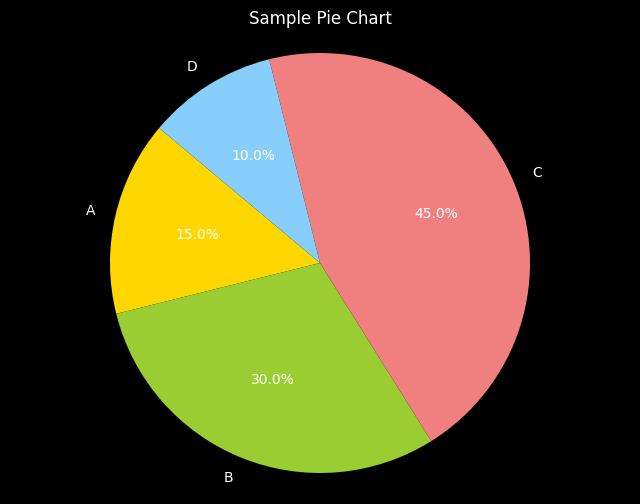

[도구 호출]
Tool: python_repl_tool
code: import matplotlib.pyplot as plt

# 데이터
sizes = [15, 30, 45, 10]
labels = ['A', 'B', 'C', 'D']
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']

# 파이 차트 그리기
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Sample Pie Chart')
plt.show()
Log: 
Invoking: `python_repl_tool` with `{'code': "import matplotlib.pyplot as plt\n\n# 데이터\nsizes = [15, 30, 45, 10]\nlabels = ['A', 'B', 'C', 'D']\ncolors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']\n\n# 파이 차트 그리기\nplt.figure(figsize=(8, 6))\nplt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)\nplt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.\nplt.title('Sample Pie Chart')\nplt.show()"}`



[관찰 내용]
Observation: 
[최종 답변]
파이 차트가 성공적으로 그려졌습니다. 차트에는 A, B, C, D의 네 가지 카테고리가 포함되어 있으며, 각 카테고리의 비율이

In [26]:
# 질의에 대한 답변을 스트리밍으로 출력 요청
result = agent_executor.stream(
    {"input": "matplotlib 을 사용하여 pie 차트를 그리는 코드를 작성하고 실행하세요."}
)

for step in result:
    # 중간 단계를 parser 를 사용하여 단계별로 출력
    agent_stream_parser.process_agent_steps(step)

In [31]:
# 다음은 callback 을 수정하여 사용하는 방법입니다.
# AgentCallbacks와 AgentStreamParser를 langchain_teddynote.messages에서 가져옵니다.
from langchain_teddynote.messages import AgentCallbacks, AgentStreamParser


# 도구 호출 시 실행되는 콜백 함수입니다.
def tool_callback(tool) -> None:
    print("<<<<<<< 도구 호출 >>>>>>")
    print(f"Tool: {tool.get('tool')}")  # 사용된 도구의 이름을 출력합니다.
    print("<<<<<<< 도구 호출 >>>>>>")


# 관찰 결과를 출력하는 콜백 함수입니다.
def observation_callback(observation) -> None:
    print("<<<<<<< 관찰 내용 >>>>>>")
    print(
        f"Observation: {observation.get('observation')[0]}"
    )  # 관찰 내용을 출력합니다.
    print("<<<<<<< 관찰 내용 >>>>>>")


# 최종 결과를 출력하는 콜백 함수입니다.
def result_callback(result: str) -> None:
    print("<<<<<<< 최종 답변 >>>>>>")
    print(result)  # 최종 답변을 출력합니다.
    print("<<<<<<< 최종 답변 >>>>>>")


# AgentCallbacks 객체를 생성하여 각 단계별 콜백 함수를 설정합니다.
agent_callbacks = AgentCallbacks(
    tool_callback=tool_callback,
    observation_callback=observation_callback,
    result_callback=result_callback,
)

# AgentStreamParser 객체를 생성하여 에이전트의 실행 과정을 파싱합니다.
agent_stream_parser = AgentStreamParser(agent_callbacks)

아래의 출력 내용을 확인해 보면 중간 내용의 출력 값이 내가 변경한 콜백 함수의 출력 값으로 변경된 것을 확인할 수 있습니다.

In [33]:
# 질의에 대한 답변을 스트리밍으로 출력 요청
result = agent_executor.stream({"input": "AI 투자관련 뉴스를 검색해 주세요."})

for step in result:
    # 중간 단계를 parser 를 사용하여 단계별로 출력
    agent_stream_parser.process_agent_steps(step)

<<<<<<< 도구 호출 >>>>>>
Tool: search_news
<<<<<<< 도구 호출 >>>>>>
<<<<<<< 관찰 내용 >>>>>>
Observation: {'url': 'https://news.google.com/rss/articles/CBMiakFVX3lxTE81QVlXam1wclZOV3loQndWUjVjU3FKUE9zMzRjbkU5b3RMSjFBaGVfMHBvM28wRDFyd05yMVhQYTVnZy1nVkhGZXBqLTV2Zks5bnFQdG8wVEtBeEJoZllhVkQwQ2d1MENteEE?oc=5', 'content': '오픈AI, 투자 유치 이후 글로벌 확장...뉴욕·파리·싱가포르 등 5곳에 지사 개설 - AI타임스'}
<<<<<<< 관찰 내용 >>>>>>
<<<<<<< 최종 답변 >>>>>>
다음은 AI 투자와 관련된 최근 뉴스 기사들입니다:

1. [오픈AI, 투자 유치 이후 글로벌 확장...뉴욕·파리·싱가포르 등 5곳에 지사 개설 - AI타임스](https://news.google.com/rss/articles/CBMiakFVX3lxTE81QVlXam1wclZOV3loQndWUjVjU3FKUE9zMzRjbkU5b3RMSjFBaGVfMHBvM28wRDFyd05yMVhQYTVnZy1nVkhGZXBqLTV2Zks5bnFQdG8wVEtBeEJoZllhVkQwQ2d1MENteEE?oc=5)

2. [오펜하이머 "MS,오픈AI 투자 손실 위험"…'중립'하향 - 한국경제](https://news.google.com/rss/articles/CBMiWkFVX3lxTE1tdU1haE5HMTRQNXZxNXRYXzBBMDVrZHYyeXEyMzNqc05jaEVPLXlaYUZ2dEVjWEVjdGxfd2lsUTZySWV0bzh2X3dEVXVpR3BXMjN4dFlzUTM2d9IBVEFVX3lxTFBBWDMxcTloY2JnSzVDU1Q1TVJ3aTZkY2lUNFVjOFlDOWVXcF8zcG10eTMtSFkzMk1HazNObURJUFpPS2VCOGhYT0FCM2d

# 이전 대화내용 기억하는 Agent
이전의 대화내용을 기억하기 위해서는 `RunnableWithMessageHistory` 를 사용하여 `AgentExecutor` 를 감싸줍니다.

`RunnableWithMessageHistory` 에 대한 자세한 내용은 아래 링크를 참고해 주세요.

참고 - [RunnableWithMessageHistory](https://wikidocs.net/254682)

In [38]:
from langchain_community.chat_message_histories import ChatMessageHistory
from langchain_core.runnables.history import RunnableWithMessageHistory

store = {}

def get_session_history(session_ids):
    if session_ids not in store: # session_id가 store에 없는경우 새로운 ChatMessageHistory 객체를 생성하여 store에 저장
        store[session_ids] = ChatMessageHistory()

    return store[session_ids]

agent_with_chat_history = RunnableWithMessageHistory(
    agent_executor,
    get_session_history,
    input_messages_key='input',
    history_messages_key="chat_history"
)

In [39]:
response = agent_with_chat_history.stream(
    {"input": "안녕? 내이름은 테디야!"},
    config={"configurable": {"session_id": "abc123"}}
)

In [40]:
for step in response:
    agent_stream_parser.process_agent_steps(step)

<<<<<<< 최종 답변 >>>>>>
안녕하세요, 테디! 만나서 반가워요. 어떻게 도와드릴까요?
<<<<<<< 최종 답변 >>>>>>


In [41]:
# 질의에 대한 답변을 스트리밍으로 출력 요청
response = agent_with_chat_history.stream(
    {"input": "내 이름이 뭐라고?"},
    # session_id 설정
    config={"configurable": {"session_id": "abc123"}},
)

# 출력 확인
for step in response:
    agent_stream_parser.process_agent_steps(step)

<<<<<<< 최종 답변 >>>>>>
당신의 이름은 테디입니다!
<<<<<<< 최종 답변 >>>>>>


In [42]:
# 질의에 대한 답변을 스트리밍으로 출력 요청
response = agent_with_chat_history.stream(
    {
        "input": "내 이메일 주소는 teddy@teddynote.com 이야. 회사 이름은 테디노트 주식회사야."
    },
    # session_id 설정
    config={"configurable": {"session_id": "abc123"}},
)

# 출력 확인
for step in response:
    agent_stream_parser.process_agent_steps(step)

<<<<<<< 최종 답변 >>>>>>
감사합니다, 테디! 테디노트 주식회사에 대해 궁금한 점이 있거나 도움이 필요하시면 말씀해 주세요. 어떤 정보를 원하시나요?
<<<<<<< 최종 답변 >>>>>>


In [43]:
# 질의에 대한 답변을 스트리밍으로 출력 요청
response = agent_with_chat_history.stream(
    {
        "input": "최신 뉴스 5개를 검색해서 이메일의 본문으로 작성해줘. "
        "수신인에는 `셜리 상무님` 그리고, 발신인에는 내 인적정보를 적어줘."
        "정중한 어조로 작성하고, 메일의 시작과 끝에는 적절한 인사말과 맺음말을 적어줘."
    },
    # session_id 설정
    config={"configurable": {"session_id": "abc123"}},
)

# 출력 확인
for step in response:
    agent_stream_parser.process_agent_steps(step)


<<<<<<< 도구 호출 >>>>>>
Tool: search_news
<<<<<<< 도구 호출 >>>>>>
<<<<<<< 관찰 내용 >>>>>>
Observation: {'url': 'https://news.google.com/rss/articles/CBMiSEFVX3lxTE9LOVpfaW1FR2pCN211MXdMM1pXMzJWT01rQlVwRzVNeU9FSVJkcDViMmQyZHZndTNvbF9jdE16UmNVRl9weXBqWQ?oc=5', 'content': '주간 이요마 인풋노트_9월 2주차 - 브런치'}
<<<<<<< 관찰 내용 >>>>>>
<<<<<<< 최종 답변 >>>>>>
아래는 셜리 상무님께 보낼 이메일 본문입니다.

---

**제목: 최신 뉴스 업데이트**

안녕하세요, 셜리 상무님.

테디노트 주식회사에 관련된 최신 뉴스를 아래와 같이 전달드립니다.

1. [주간 이요마 인풋노트_9월 2주차 - 브런치](https://news.google.com/rss/articles/CBMiSEFVX3lxTE9LOVpfaW1FR2pCN211MXdMM1pXMzJWT01rQlVwRzVNeU9FSVJkcDViMmQyZHZndTNvbF9jdE16UmNVRl9weXBqWQ?oc=5)
2. ['형형색색' 갤럭시노트9, 이렇게 생겼을까 - ZD넷 코리아](https://news.google.com/rss/articles/CBMiVkFVX3lxTE10V0F6Y3czcHlCcENSMkZuMFZDTEI2d3BMbklyY1EtbWk1blU4dDNCSlJ2NUVKa2VDb1hEdGM0MzdtUmZPM1FGSC0zcWdQREl0OENZNlNB?oc=5)
3. [아티제, 가로수길 커피 팝업스토어 오픈 - 한국경제](https://news.google.com/rss/articles/CBMiWkFVX3lxTE43NDkxMDE5VEZsbE41SkREWlFZUGRlV3pwVkVtSWpYajhoOW5qcnROWHlvRkJSTmczeUgyeFFvTmFwOEl1SzAwcjdUbGdhSDR4U

In [47]:
# result = agent_executor.invoke({"input": "matplotlib 을 사용하여 pie 차트를 그리는 코드를 작성하고 실행하세요. 해당 코드도 알려주세요"})
# print("Agent 실행 결과:")
# print(result["output"])

# 질의에 대한 답변을 스트리밍으로 출력 요청
response = agent_with_chat_history.invoke(
    {
        "input": "최신 뉴스 5개를 검색해서 이메일의 본문으로 작성해줘. "
        "수신인에는 `셜리 상무님` 그리고, 발신인에는 내 인적정보를 적어줘."
        "정중한 어조로 작성하고, 메일의 시작과 끝에는 적절한 인사말과 맺음말을 적어줘."
    },
    # session_id 설정
    config={"configurable": {"session_id": "abc123"}},
)

print("Agent 실행 결과:")
print(response["output"])

Agent 실행 결과:
아래는 셜리 상무님께 보낼 이메일 본문입니다.

---

**제목: 최신 뉴스 업데이트**

안녕하세요, 셜리 상무님.

테디노트 주식회사에 관련된 최신 뉴스를 아래와 같이 전달드립니다.

1. [주간 이요마 인풋노트_9월 2주차 - 브런치](https://news.google.com/rss/articles/CBMiSEFVX3lxTE9LOVpfaW1FR2pCN211MXdMM1pXMzJWT01rQlVwRzVNeU9FSVJkcDViMmQyZHZndTNvbF9jdE16UmNVRl9weXBqWQ?oc=5)
2. ['형형색색' 갤럭시노트9, 이렇게 생겼을까 - ZD넷 코리아](https://news.google.com/rss/articles/CBMiVkFVX3lxTE10V0F6Y3czcHlCcENSMkZuMFZDTEI2d3BMbklyY1EtbWk1blU4dDNCSlJ2NUVKa2VDb1hEdGM0MzdtUmZPM1FGSC0zcWdQREl0OENZNlNB?oc=5)
3. [아티제, 가로수길 커피 팝업스토어 오픈 - 한국경제](https://news.google.com/rss/articles/CBMiWkFVX3lxTE43NDkxMDE5VEZsbE41SkREWlFZUGRlV3pwVkVtSWpYajhoOW5qcnROWHlvRkJSTmczeUgyeFFvTmFwOEl1SzAwcjdUbGdhSDR4U2x6QUg0V1N4d9IBVEFVX3lxTFA4cXFVMk5Ec3ZWdEZ4akd6ZWxfa3Z0ejRQQm1YeU9fOWJwY2tZd25SaTNoTnNIdkxuckdqWU4zaUN1U1lXd1ZDaW5JZVJoN0ZtZmRveQ?oc=5)
4. [[POP이슈]타블로→테디→싸이, 한 지붕 세 레이블 가지뻗는 YG - ZUM 뉴스](https://news.google.com/rss/articles/CBMiT0FVX3lxTFBhczV6U3lPOEdnZEszTHVRSXRiT3JxLUpxUnloSFlqWHJzTFdUWktTS204Zkk4ZFU3ZjNXUndGVS1SV1

In [48]:
# result = agent_executor.invoke({"input": "matplotlib 을 사용하여 pie 차트를 그리는 코드를 작성하고 실행하세요. 해당 코드도 알려주세요"})
# print("Agent 실행 결과:")
# print(result["output"])

# 질의에 대한 답변을 스트리밍으로 출력 요청
response = agent_with_chat_history.invoke(
    {
        "input": "최신 뉴스 5개를 검색해서 이메일의 본문으로 작성해줘. "
        "수신인에는 `셜리 상무님` 그리고, 발신인에는 내 인적정보를 적어줘."
        "정중한 어조로 작성하고, 메일의 시작과 끝에는 적절한 인사말과 맺음말을 적어줘."
    },
    # session_id 설정
    config={"configurable": {"session_id": "abc123"}},
)

# print("Agent 실행 결과:")
# print(response["output"])

In [44]:
# 질의에 대한 답변을 스트리밍으로 출력 요청
response = agent_with_chat_history.stream(
    {
        "input": "최신 뉴스 5개를 검색해서 이메일의 본문으로 작성해줘. "
        "수신인에는 `셜리 상무님` 그리고, 발신인에는 내 인적정보를 적어줘."
        "정중한 어조로 작성하고, 메일의 시작과 끝에는 적절한 인사말과 맺음말을 적어줘."
    },
    # session_id 설정
    config={"configurable": {"session_id": "abc123"}},
)

# 출력 확인
for step in response:
    print(step)

{'actions': [ToolAgentAction(tool='search_news', tool_input={'query': '테디노트'}, log="\nInvoking: `search_news` with `{'query': '테디노트'}`\n\n\n", message_log=[AIMessageChunk(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_rWrvq35WsOl76cbJVv91GBpq', 'function': {'arguments': '{"query":"테디노트"}', 'name': 'search_news'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_e2bde53e6e'}, id='run-407dfb41-3f1d-4bcf-9caf-e77657b64954', tool_calls=[{'name': 'search_news', 'args': {'query': '테디노트'}, 'id': 'call_rWrvq35WsOl76cbJVv91GBpq', 'type': 'tool_call'}], tool_call_chunks=[{'name': 'search_news', 'args': '{"query":"테디노트"}', 'id': 'call_rWrvq35WsOl76cbJVv91GBpq', 'index': 0, 'type': 'tool_call_chunk'}])], tool_call_id='call_rWrvq35WsOl76cbJVv91GBpq')], 'messages': [AIMessageChunk(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_rWrvq35WsOl76cbJVv91GBpq', 'function'